<a href="https://colab.research.google.com/github/eborin/SSL-course/blob/main/08_minerva_data_transforms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[View Source Code](https://github.com/eborin/SSL-course/blob/main/08_minerva_data_transforms.ipynb)

# Data Transformations and Views for Contrastive Learning

This notebook demonstrates how to apply data transformations to dataset samples in order to generate multiple views for contrastive learning.
Specifically, it showcases how to use various `torchvision` transformations on the STL10 dataset from the `torchvision` library.

## <a id="sec_1">1. Introduction</a>

### 1.1 Objective

The main objective of this tutorial is to discuss how transforms can be employed to generate views for contrastive self-supervised learning.

### 1.2 Data Transforms

In PyTorch, a data transform is an operation—or a sequence of operations—applied to input data, typically images, before feeding it into a neural network.
The [`torchvision.transforms`](https://pytorch.org/tutorials/beginner/basics/transforms_tutorial.html#transforms) module provides a comprehensive suite of transformations commonly used for data preprocessing (e.g., resizing, normalization) and data augmentation (e.g., flipping, cropping, adding noise).

These transforms help standardize input formats and enhance dataset variability, which is crucial for effective training.
Operations like resizing, cropping, flipping, rotation, and color jittering can be composed using [`transforms.Compose()`](https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html) and applied either during dataset initialization or dynamically during training.
This approach improves model performance without requiring manual modifications to the original dataset.

### 1.3 Data Transforms for Contrastive Learning

Data transforms play a key role in contrastive learning, where the goal is to generate multiple augmented "views" of the same input to learn meaningful and discriminative representations.
By applying random combinations of transformations to a single image, the model is encouraged to identify features that remain consistent across varied appearances.

This strategy helps the model become invariant to superficial changes like lighting, orientation, or color—ultimately leading to more robust and generalizable representations that perform well even with limited labeled data.

### 1.4 What we're going to cover

In this tutorial, we’ll demonstrate how to use the [Minerva framework](https://github.com/discovery-unicamp/Minerva) to build and train a model for a computer vision task.
Specifically, we will build a supervised model by combining a pretrained backbone (ResNet50 from `torchvision`) with a prediction head and train them so solve the STL10 image classification task using the Minerva framework.

| **Topic** | **Contents** |
| ----- | ----- |
| [**2. Basic setup**](#sec_2) | Import useful modules (torch, torchvision, and minerva). |
| [**3. Applying data transform to dataset samples**](#sec_3) | Discusses how to apply data transforms to dataset samples. |
| [**4. Exploring the effect of transforms on dataset samples**](#sec_4) | Explores how different transforms affect individual samples from the dataset. |
| [**5. Bringing It All Together**](#sec_5) | Combines all the previously discussed transforms by (i) creating a single transformation pipeline that applies them sequentially, and (ii) using a Minerva transform to generate two distinct augmented versions of the same input—a common approach in contrastive self-supervised learning. |
| [**6. Exercises**](#sec_6) | Suggested Exercises. |

### 1.5 Where can you get help?

In addition to discussing with your colleagues or the course professor, you might also consider:

* PyTorch: check the [PyTorch Docs: Transforming and augmenting images](https://pytorch.org/vision/main/transforms.html) and research or post PyTorch related question on the [PyTorch developer forums](https://discuss.pytorch.org/).

## <a id="sec_2">2. Basic setup</a>

### 2.1 Installing the Minerva module

The code below attempts to import the Minerva module and installs it automatically if it is not already available.

In [1]:
try:
    import minerva
except:
    try:
        #Try to install it and import again
        print("[INFO]: Could not import the minerva module. Trying to install it!")
        !pip install -q minerva-ml
        import minerva
        print("[INFO]: It looks like minerva was successfully imported!")
    except:
        raise Exception("[ERROR] Couldn't find the minerva module ... \n" +
                        "Please, install it before running the notebook.\n"+
                        "You might want to install the modules listed at requirements.txt\n" +
                        "To do so, run: \"pip install -r requirements.txt\"")

[INFO]: Could not import the minerva module. Trying to install it!
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.6/160.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.0/223.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5

### 2.2 Importing basic modules

In [2]:
# Import PyTorch
import torch

# Import torchvision
import torchvision

# Import minerva
import minerva

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")
#print(f"Minerva version: {minerva.__version__}") ## TODO

# Import matplotlib for visualization
import matplotlib.pyplot as plt

PyTorch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124


## <a id='sec_3'>3. Applying data transforms to dataset samples</a>

Let's begin by exploring how to apply data transforms to dataset samples.

For these experiments, we’ll use the unlabeled split of the STL10 dataset.
This choice is intentional, as we plan to use this split for self-supervised pre-training in upcoming tutorials.

### 3.1 Downloading the dataset

The following code downloads the unlabeled split of STL10 dataset using the `torchvision` module.
Let's start without any data transformation.

In [3]:
dataset = torchvision.datasets.STL10(root="data",
                                     split="unlabeled",
                                     download=True)

100%|██████████| 2.64G/2.64G [01:47<00:00, 24.6MB/s]


### 3.2 Inspecting the samples

Done, now lets inspect the first sample.

In [4]:
sample = dataset[0]

print("type(sample):", type(sample))
print("len(sample):", len(sample))


type(sample): <class 'tuple'>
len(sample): 2


It is a tuple with two values. Let's inspect its contents.

In [5]:
print("**** sample[0] ****")
print("type(sample[0]):", type(sample[0]))
print("sample[0]:", sample[0])

print("\n**** sample[1] ****")
print("type(sample[1]):", type(sample[1]))
print("sample[1]:", sample[1])

**** sample[0] ****
type(sample[0]): <class 'PIL.Image.Image'>
sample[0]: <PIL.Image.Image image mode=RGB size=96x96 at 0x7E70368A3810>

**** sample[1] ****
type(sample[1]): <class 'int'>
sample[1]: -1


As with previous datasets, each sample is represented as a tuple with two elements: the first contains the input features, and the second is an integer label, consistent with the label format used in other datasets.
Although this split is unlabeled—and thus shouldn't have true labels—we return a placeholder (or "fake") label to maintain consistency in the data structure.
This approach simplifies the overall code design by avoiding the need for special handling of unlabeled data.

From this point forward, we’ll disregard the label and focus solely on the input features.

In [6]:
sample_features, _ = dataset[0]
type(sample_features)

PIL.Image.Image

We can plot PIL images using matplotlib as follows.

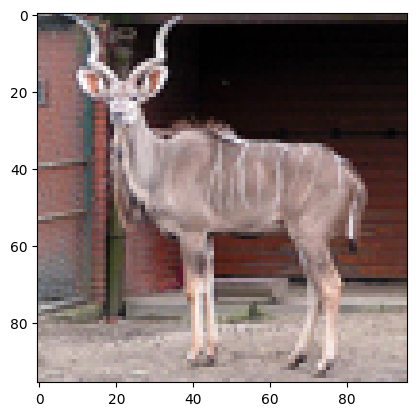

In [7]:
import matplotlib.pyplot as plt

plt.imshow(sample_features)
plt.show()

### 3.3 Converting PIL images to tensors

The features are represented as a PIL image, which is a format commonly used in `torchvision` datasets.
As discussed in tutorial `05_pytorch_transfer_learning.ipynb`, we usually transform PIL images to PyTorch tensors when training and/or evaluating PyTorch models.
This can be conveniently done using the `ToTensor()` function, made available by `torchvision.transforms` module, as follows.

In [8]:
to_tensor_transform = torchvision.transforms.ToTensor()

tensor = to_tensor_transform(sample_features)

print("type:", type(tensor))
print("shape:", tensor.shape)
print("array:", tensor)

type: <class 'torch.Tensor'>
shape: torch.Size([3, 96, 96])
array: tensor([[[0.4941, 0.5647, 0.5882,  ..., 0.2196, 0.2275, 0.2353],
         [0.2863, 0.2588, 0.2314,  ..., 0.2510, 0.2157, 0.2314],
         [0.2353, 0.2314, 0.2078,  ..., 0.0863, 0.0667, 0.0941],
         ...,
         [0.7137, 0.7412, 0.7961,  ..., 0.6471, 0.6471, 0.6275],
         [0.7608, 0.7882, 0.6980,  ..., 0.6902, 0.6902, 0.7255],
         [0.6980, 0.6745, 0.7059,  ..., 0.6824, 0.6353, 0.6275]],

        [[0.5020, 0.5412, 0.6000,  ..., 0.1804, 0.2000, 0.1922],
         [0.3137, 0.2667, 0.2471,  ..., 0.1961, 0.2000, 0.2000],
         [0.2235, 0.2549, 0.2314,  ..., 0.0627, 0.0627, 0.0627],
         ...,
         [0.6824, 0.6745, 0.7490,  ..., 0.6000, 0.6235, 0.5961],
         [0.7137, 0.7490, 0.6471,  ..., 0.6431, 0.6392, 0.6745],
         [0.6353, 0.6353, 0.6627,  ..., 0.6510, 0.5843, 0.5804]],

        [[0.5059, 0.5569, 0.6039,  ..., 0.1804, 0.1686, 0.1882],
         [0.3490, 0.2941, 0.2824,  ..., 0.2118, 0.1608, 

As we can see, the `ToTensor()` transform converts the image into a tensor of shape `3 × 96 × 96`, representing a 3-channel image with dimensions `96×96`.
The pixel values are scaled to the range `[0.0, 1.0]`—this is because the original PIL image stores pixel intensities as 8-bit unsigned integers ranging from 0 to 255.
The `ToTensor()` transform normalizes these values by dividing them by 255, converting them into floating-point numbers suitable for neural network processing.

We can also visualize the image using Matplotlib.
Since Matplotlib expects image arrays in the format `Height × Width × Channels`, we will use the `permute()` function to rearrange the tensor dimensions from `Channels × Height × Width` to the expected format.

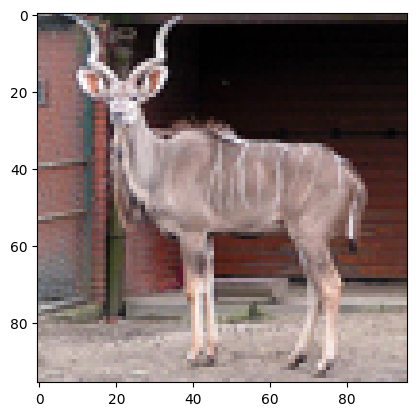

In [9]:
import matplotlib.pyplot as plt

plt.imshow(tensor.permute(1, 2, 0))
plt.show()

#### Deprecation of ToTensor() method

As of April 2025, the Torchvision documentation states that:

> "`v2.ToTensor` is deprecated and will be removed in a future release. Please use instead `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`. Output is equivalent up to float precision."

As we will explore later, the `Compose()` transform allows us to build a transformation pipeline by chaining together a list of individual transforms, applying them sequentially to each input.

For now, let's take a closer look at what each of these transformations does.

In [10]:
from torchvision.transforms.v2 import ToImage

to_image = ToImage()
image = to_image(sample_features)

print("type:", type(image))
print("shape:", image.shape)
print("array:", image)

type: <class 'torchvision.tv_tensors._image.Image'>
shape: torch.Size([3, 96, 96])
array: Image([[[126, 144, 150,  ...,  56,  58,  60],
        [ 73,  66,  59,  ...,  64,  55,  59],
        [ 60,  59,  53,  ...,  22,  17,  24],
        ...,
        [182, 189, 203,  ..., 165, 165, 160],
        [194, 201, 178,  ..., 176, 176, 185],
        [178, 172, 180,  ..., 174, 162, 160]],

       [[128, 138, 153,  ...,  46,  51,  49],
        [ 80,  68,  63,  ...,  50,  51,  51],
        [ 57,  65,  59,  ...,  16,  16,  16],
        ...,
        [174, 172, 191,  ..., 153, 159, 152],
        [182, 191, 165,  ..., 164, 163, 172],
        [162, 162, 169,  ..., 166, 149, 148]],

       [[129, 142, 154,  ...,  46,  43,  48],
        [ 89,  75,  72,  ...,  54,  41,  49],
        [ 69,  65,  60,  ...,  18,  13,  17],
        ...,
        [168, 169, 186,  ..., 160, 160, 154],
        [180, 187, 164,  ..., 163, 160, 169],
        [160, 154, 163,  ..., 160, 146, 147]]], dtype=torch.uint8, )


The `ToImage()` transform converts the input into a `torchvision.tv_tensors._image.Image` object, which stores data using the `torch.uint8` data type—similar to a PIL image.
However, it arranges the tensor in `Channels × Width × Height` (C × W × H) format, aligning with the layout used by `ToTensor()`.

Now, let's see the effect of `ToDtype(torch.float32, scale=True)`.

In [11]:
from torchvision.transforms.v2 import ToDtype

to_dtype_f32_scale = ToDtype(torch.float32, scale=True)

t = to_dtype_f32_scale(image)

print("type:", type(t))
print("shape:", t.shape)
print("array:", t)

type: <class 'torchvision.tv_tensors._image.Image'>
shape: torch.Size([3, 96, 96])
array: Image([[[0.4941, 0.5647, 0.5882,  ..., 0.2196, 0.2275, 0.2353],
        [0.2863, 0.2588, 0.2314,  ..., 0.2510, 0.2157, 0.2314],
        [0.2353, 0.2314, 0.2078,  ..., 0.0863, 0.0667, 0.0941],
        ...,
        [0.7137, 0.7412, 0.7961,  ..., 0.6471, 0.6471, 0.6275],
        [0.7608, 0.7882, 0.6980,  ..., 0.6902, 0.6902, 0.7255],
        [0.6980, 0.6745, 0.7059,  ..., 0.6824, 0.6353, 0.6275]],

       [[0.5020, 0.5412, 0.6000,  ..., 0.1804, 0.2000, 0.1922],
        [0.3137, 0.2667, 0.2471,  ..., 0.1961, 0.2000, 0.2000],
        [0.2235, 0.2549, 0.2314,  ..., 0.0627, 0.0627, 0.0627],
        ...,
        [0.6824, 0.6745, 0.7490,  ..., 0.6000, 0.6235, 0.5961],
        [0.7137, 0.7490, 0.6471,  ..., 0.6431, 0.6392, 0.6745],
        [0.6353, 0.6353, 0.6627,  ..., 0.6510, 0.5843, 0.5804]],

       [[0.5059, 0.5569, 0.6039,  ..., 0.1804, 0.1686, 0.1882],
        [0.3490, 0.2941, 0.2824,  ..., 0.2118, 0

Still not a PyTorch tensor, but it's contents are very similar to the tensor produced by `ToTensor()`.

Let’s combine both transforms using `Compose()` to create a transformation pipeline.

In [12]:
from torchvision.transforms.v2 import Compose

PIL_to_tensor = Compose([ToImage(), ToDtype(torch.float32, scale=True)])

t = PIL_to_tensor(sample_features)

print("type:", type(t))
print("shape:", t.shape)
print("array:", t)


type: <class 'torchvision.tv_tensors._image.Image'>
shape: torch.Size([3, 96, 96])
array: Image([[[0.4941, 0.5647, 0.5882,  ..., 0.2196, 0.2275, 0.2353],
        [0.2863, 0.2588, 0.2314,  ..., 0.2510, 0.2157, 0.2314],
        [0.2353, 0.2314, 0.2078,  ..., 0.0863, 0.0667, 0.0941],
        ...,
        [0.7137, 0.7412, 0.7961,  ..., 0.6471, 0.6471, 0.6275],
        [0.7608, 0.7882, 0.6980,  ..., 0.6902, 0.6902, 0.7255],
        [0.6980, 0.6745, 0.7059,  ..., 0.6824, 0.6353, 0.6275]],

       [[0.5020, 0.5412, 0.6000,  ..., 0.1804, 0.2000, 0.1922],
        [0.3137, 0.2667, 0.2471,  ..., 0.1961, 0.2000, 0.2000],
        [0.2235, 0.2549, 0.2314,  ..., 0.0627, 0.0627, 0.0627],
        ...,
        [0.6824, 0.6745, 0.7490,  ..., 0.6000, 0.6235, 0.5961],
        [0.7137, 0.7490, 0.6471,  ..., 0.6431, 0.6392, 0.6745],
        [0.6353, 0.6353, 0.6627,  ..., 0.6510, 0.5843, 0.5804]],

       [[0.5059, 0.5569, 0.6039,  ..., 0.1804, 0.1686, 0.1882],
        [0.3490, 0.2941, 0.2824,  ..., 0.2118, 0

### 3.4 Adapting the Dataset to Use a Transform Pipeline

As discussed in earlier tutorials, we can attach data transforms directly to a dataset so that each sample is automatically transformed when retrieved.

By using the `Compose()` method, we can chain together multiple transformations into a single, unified pipeline, as shown below.

In [13]:
from torchvision.transforms.v2 import Compose, ToImage, ToDtype

transform_pipeline = Compose([ToImage(), ToDtype(torch.float32, scale=True)])

dataset = torchvision.datasets.STL10(root="data",
                                     split="unlabeled",
                                     download=True,
                                     transform=transform_pipeline)

Done, now whenever we retrieve a sample, it will be automatically transformed by the applying the `ToImage()` and the `ToDtype()` data transforms.

For example:

In [14]:
sample_features, _ = dataset[0]

print("type:", type(sample_features))
print("shape:", sample_features.shape)
print("array:", sample_features)

type: <class 'torchvision.tv_tensors._image.Image'>
shape: torch.Size([3, 96, 96])
array: Image([[[0.4941, 0.5647, 0.5882,  ..., 0.2196, 0.2275, 0.2353],
        [0.2863, 0.2588, 0.2314,  ..., 0.2510, 0.2157, 0.2314],
        [0.2353, 0.2314, 0.2078,  ..., 0.0863, 0.0667, 0.0941],
        ...,
        [0.7137, 0.7412, 0.7961,  ..., 0.6471, 0.6471, 0.6275],
        [0.7608, 0.7882, 0.6980,  ..., 0.6902, 0.6902, 0.7255],
        [0.6980, 0.6745, 0.7059,  ..., 0.6824, 0.6353, 0.6275]],

       [[0.5020, 0.5412, 0.6000,  ..., 0.1804, 0.2000, 0.1922],
        [0.3137, 0.2667, 0.2471,  ..., 0.1961, 0.2000, 0.2000],
        [0.2235, 0.2549, 0.2314,  ..., 0.0627, 0.0627, 0.0627],
        ...,
        [0.6824, 0.6745, 0.7490,  ..., 0.6000, 0.6235, 0.5961],
        [0.7137, 0.7490, 0.6471,  ..., 0.6431, 0.6392, 0.6745],
        [0.6353, 0.6353, 0.6627,  ..., 0.6510, 0.5843, 0.5804]],

       [[0.5059, 0.5569, 0.6039,  ..., 0.1804, 0.1686, 0.1882],
        [0.3490, 0.2941, 0.2824,  ..., 0.2118, 0

From this point on, we will use this updated dataset to explore additional data transformations.

## <a id='sec_4'>4. Exploring the effect of transforms on dataset samples</a>

Let's explore how different transforms affect individual samples from the dataset.

There are several [computer vision transformations available at `torchvision` module](https://pytorch.org/vision/stable/transforms.html).
Most transformations accept both PIL images and tensor inputs. Both CPU and CUDA tensors are also supported.
The documentation states that the result of both backends (PIL or Tensors images) should be very close.
However, in general, it recommends relying on the tensor backend for performance.

Tensor image are expected to be of shape (C, H, W), where C is the number of channels, and H and W refer to height and width.

### 4.1 Visualization code

The following code displays images in a grid layout and will be used in the upcoming sections to illustrate the effects of various data transformations.



In [15]:
def plot_grid_of_images(columns_contents,   # Dictionary with columns contents
                        fig_scale_factor=3, # Scale factor (change image size)
                        title=None          # Figure title
                        ):
    # Number of columns
    ncols = len(columns_contents)
    # Number of rows
    nrows = 0
    for col_name, col_images in columns_contents.items():
        if len(col_images) > nrows:
            nrows = len(col_images)

    fig = plt.figure(figsize=(fig_scale_factor*ncols, fig_scale_factor*nrows))
    plt.axis(False)
    if title:
        plt.title(title)
    # For each row
    img_idx = 1
    for row_idx in range(nrows):
        # For each col
        for col_name, col_images in columns_contents.items():
            ax = fig.add_subplot(nrows, ncols, img_idx)
            img_idx += 1
            if row_idx < len(col_images):
                img = col_images[row_idx].permute(1,2,0)
                plt.imshow(img)
            if row_idx == 0:
                ax.set_title(col_name)


    plt.show()

Now we can plot grids with images from a dictionary of columns.
Each dictionary entry is identified by a key that corresponds to the column name and contains a list of images to be displayed.

For example:

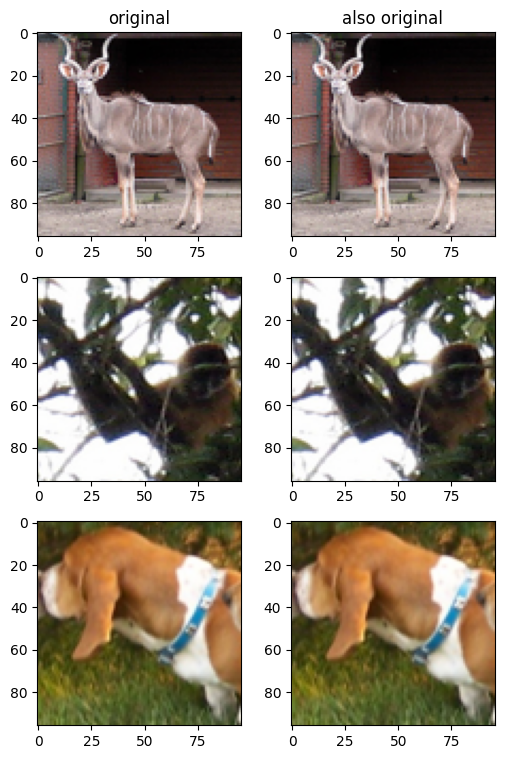

In [16]:
images = [dataset[0][0], dataset[42][0], dataset[96][0]]

columns_contents = {
    "original": images,
    "also original": images
}

plot_grid_of_images(columns_contents)

### 4.2 Random Horizontal Flip

The `RandomHorizontalFlip(p)` transform flips an input image horizontally with a given probability p (default is 0.5, or 50%).

The code below instantiates this transform, applies it to four dataset samples, and displays the results in a grid.

Since the transform is applied randomly with a 50% chance, you may observe different outputs each time you re-run the code cell.

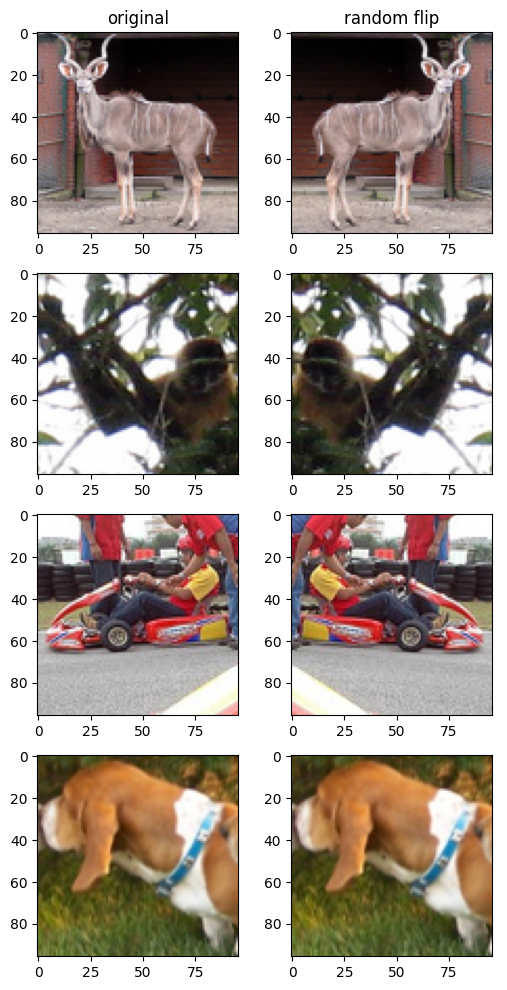

In [17]:
from torchvision.transforms.v2 import RandomHorizontalFlip

# Instantiate a random horizontal flip transform object with probability of 50%.
random_flip = RandomHorizontalFlip(0.5)

# Select some random samples from dataset
original_samples = [dataset[0][0], dataset[42][0], dataset[51][0], dataset[96][0]]

# Transform them using the random horizontal flip transform
randomly_flipped_samples = [random_flip(sample) for sample in original_samples]

# Plot the samples
plot_grid_of_images({
    "original": original_samples,
    "random flip": randomly_flipped_samples
})

### 4.3 Random Resized Crop

The `RandomResizedCrop(p)` crops a random portion of the input and resize it to a given size.

The code below instantiates this transform, applies it to the same samples explored earlier, and displays the results in a grid.

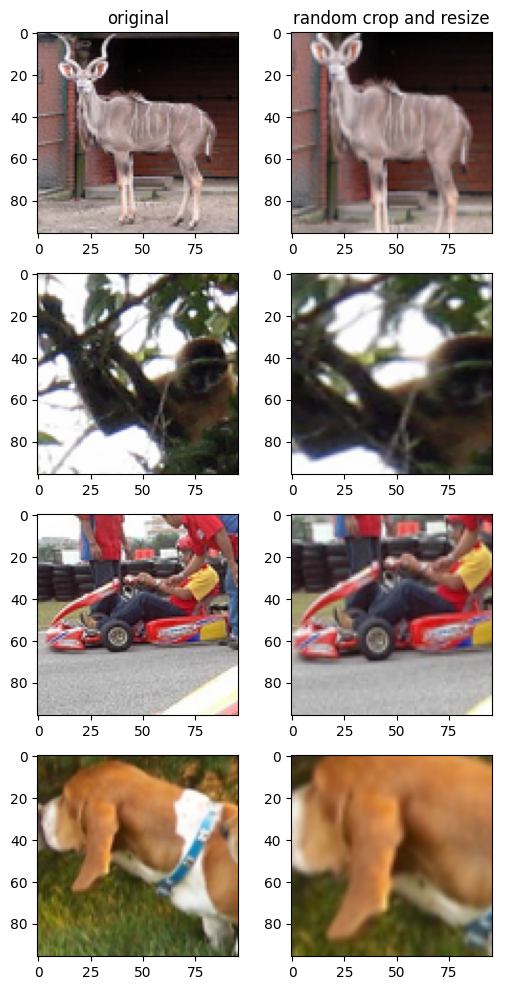

In [18]:
from torchvision.transforms.v2 import RandomResizedCrop

# Randomly crop the the image and resizes to its original size, i.e., 96x96
random_rsz_crop = RandomResizedCrop(size=(96,96))

# Apply the transform to the original samples
randomly_rsz_crop_samples = [random_rsz_crop(sample) for sample in original_samples]

# Plot the samples
plot_grid_of_images({
    "original": original_samples,
    "random crop and resize": randomly_rsz_crop_samples
})

Note that the effect resembles zooming into a random region of the image.

### 4.4 Random Color Jitter

The [`ColorJitter()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.ColorJitter.html#torchvision.transforms.ColorJitter) transform randomly adjusts the brightness, contrast, saturation, and hue of an image.

Each of these properties is altered independently, introducing varied color distortions that enhance data diversity.
To control the likelihood of applying this transformation, we can wrap it with the `RandomApply()` method, which specifies a probability for the transform to be applied.

The code below demonstrates how to combine `ColorJitter()` with `RandomApply()` to apply color jittering selectively.

Again, if you execute this code block multiple times you are likely to get different results.

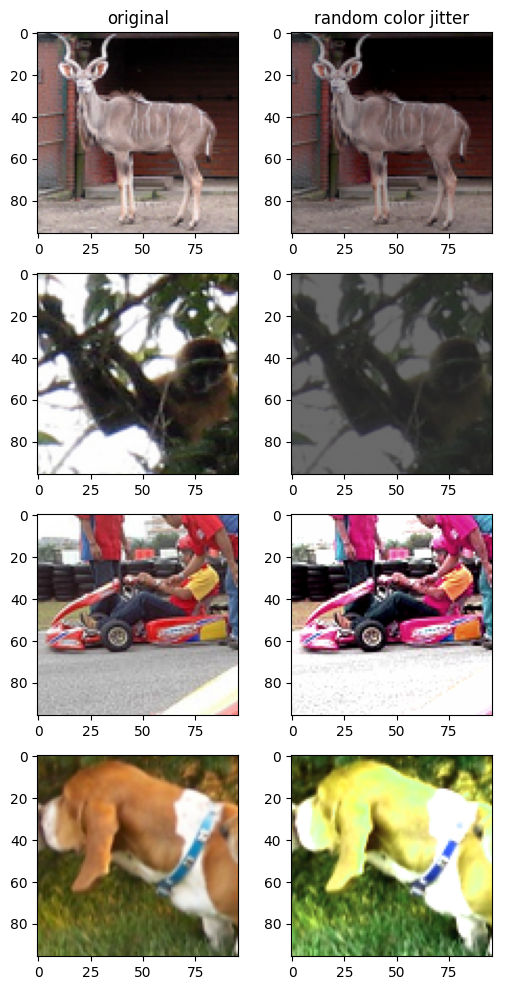

In [19]:
from torchvision.transforms.v2 import RandomApply, ColorJitter

# Randomly crop the the image and resizes to its original size, i.e., 96x96
transform = RandomApply([ColorJitter(brightness=0.5,contrast=0.5,saturation=0.5,hue=0.1)], p=0.8)

# Apply the transform to the original samples
random_color_jitter = [transform(sample) for sample in original_samples]

# Plot the samples
columns_contents = {
    "original": original_samples,
    "random color jitter": random_color_jitter
}
plot_grid_of_images(columns_contents)

### 4.5 Random Grayscale

The `RandomGrayscale()` transform randomly converts images or videos to grayscale with a probability of p (default 0.1).

The code below demonstrates how this transform affects the dataset samples.

Once again, if you execute this code block multiple times you are likely to get different results.

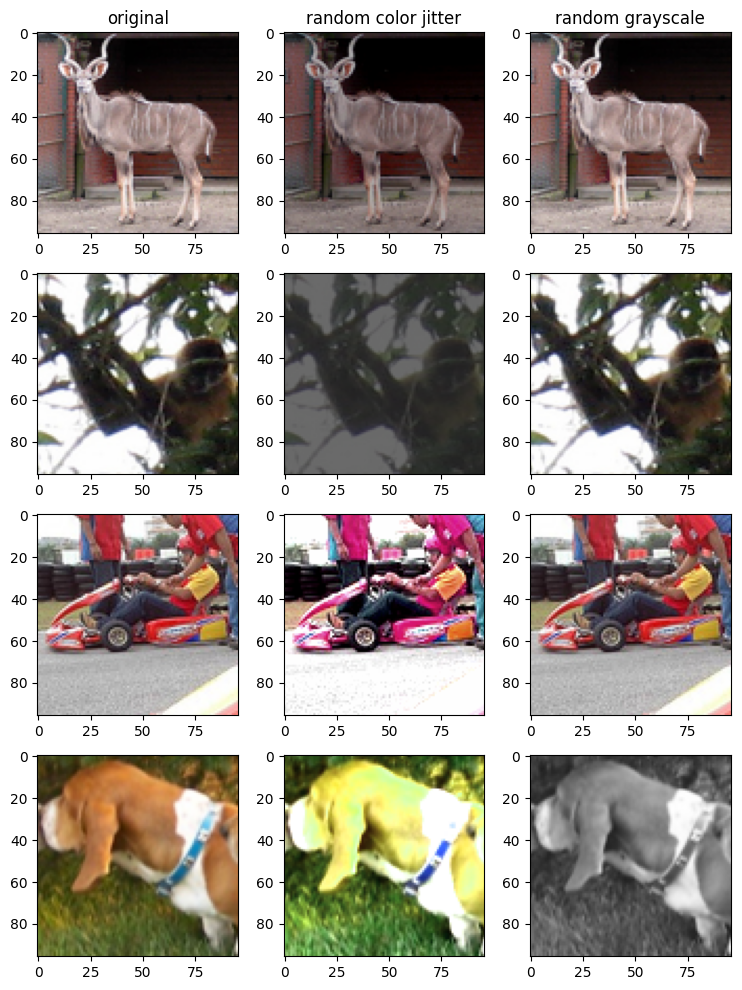

In [20]:
from torchvision.transforms.v2 import RandomGrayscale

transform = RandomGrayscale(p=0.5)

# Apply the transform to the original samples
random_grayscale = [transform(sample) for sample in original_samples]

# Plot the samples
plot_grid_of_images({
    "original": original_samples,
    "random color jitter": random_color_jitter,
    "random grayscale": random_grayscale
})

### 4.6 GaussianBlur

The `GaussianBlur()` transform blurs the image with randomly chosen Gaussian blur kernel.

The code below demonstrates how this transform affects the dataset samples.

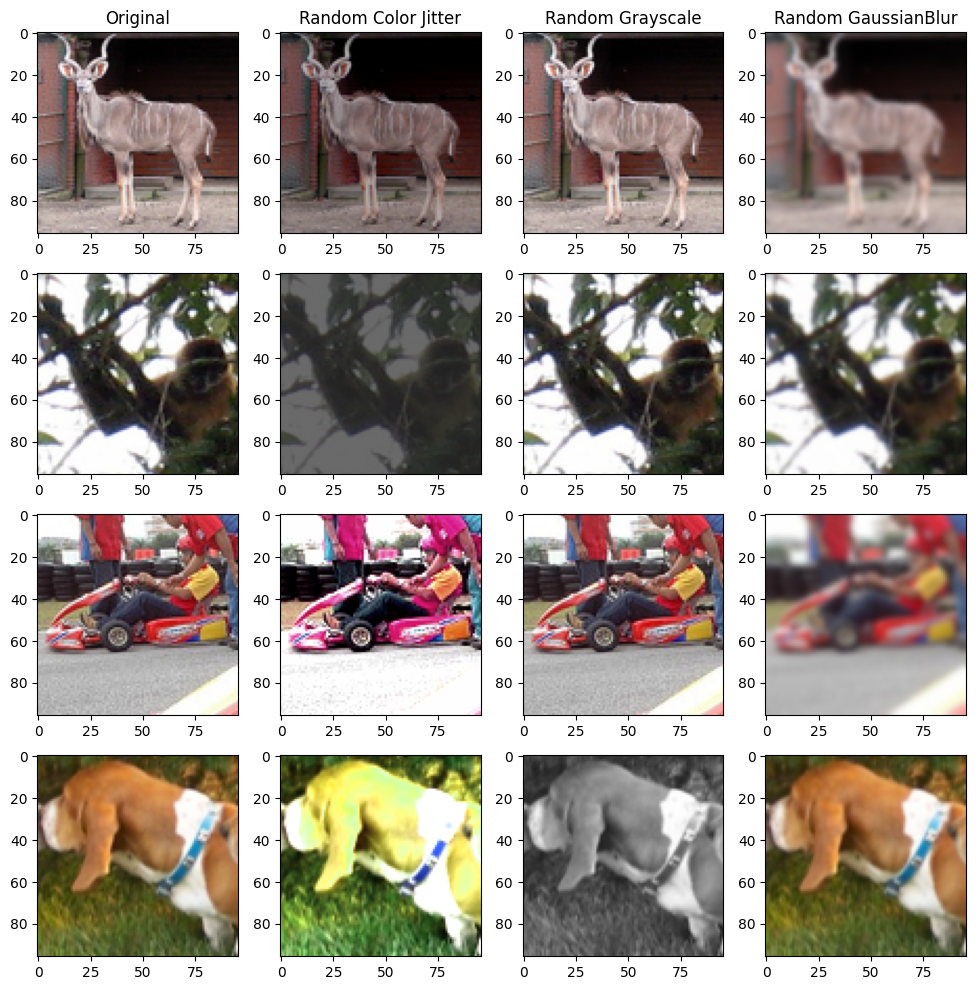

In [21]:
from torchvision.transforms.v2 import GaussianBlur

transform = GaussianBlur(kernel_size=9)

# Apply the transform to the original samples
random_gaussian_blur = [transform(sample) for sample in original_samples]

# Plot the samples
plot_grid_of_images({
    "Original": original_samples,
    "Random Color Jitter": random_color_jitter,
    "Random Grayscale": random_grayscale,
    "Random GaussianBlur": random_gaussian_blur
})

### 4.7 Normalization

Normalization is a common preprocessing step in training machine learning models.
For image data, it typically involves adjusting the pixel value distribution so that the mean is 0.0 and the standard deviation is 1.0.

The code below demonstrates how to normalize a sample using the mean and standard deviation calculated from the unlabeled split of the STL10 dataset.

In [22]:
from torchvision.transforms.v2 import Normalize

# STL10 statistics for the unlabeled split.
# - Note: If you would like to compute these statistics for your own dataset, refer
#         to the discussion in tutorial 05_pytorch_transfer_learning.ipynb.
stl10_unlabeled_mean  = torch.tensor([0.4406, 0.4273, 0.3858])
stl10_unlabeled_std = torch.tensor([0.2687, 0.2613, 0.2685])

transform = Normalize(mean=stl10_unlabeled_mean, std=stl10_unlabeled_std)

# Apply the transform to the original samples
normalized_samples = [transform(sample) for sample in original_samples]

#### Effect of normalization on visualization

The following code shows the effect of normalization on data visualization.

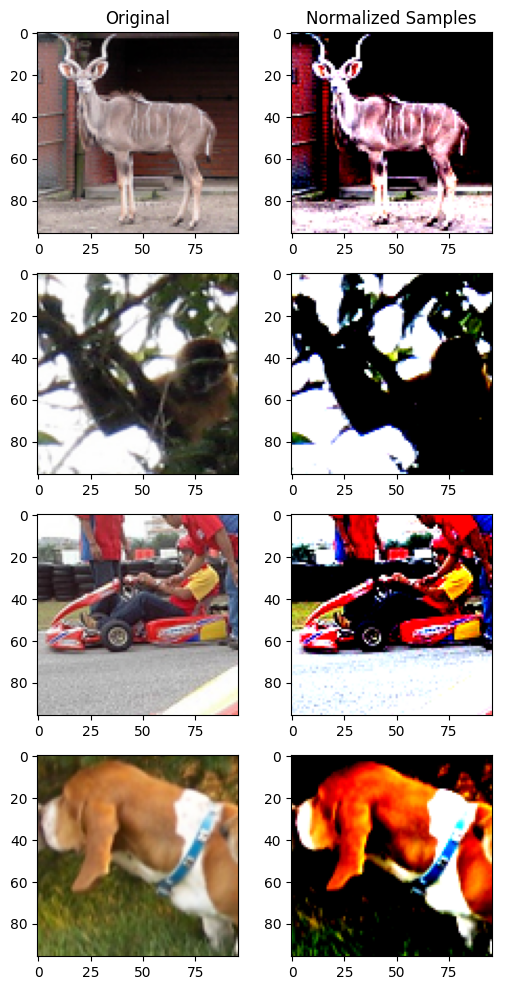

In [23]:
# Plot the samples
plot_grid_of_images({
    "Original": original_samples,
    "Normalized Samples": normalized_samples
})

Note that Matplotlib's `imshow` function issued a warning about the image values—it expects input values to be in the range `[0.0, 1.0]`.
This warning occurs because the normalization transform shifts the pixel values, potentially moving them outside this expected range.
In fact, since the normalization centers the mean at zero, it's common for the image data to contain negative values.

As a result, `imshow` clips the values to the `[0.0, 1.0]` range, which can lead to a distorted visualization of the image.
To display the image more accurately, we would need to de-normalize it before plotting.

To de-normalize an image, we first multiply the pixel values by the standard deviation (equivalent to dividing by the inverse of the standard deviation), and then add the mean (equivalent to subtracting the negative mean).
The following code demonstrates how to de-normalize a previously normalized image.

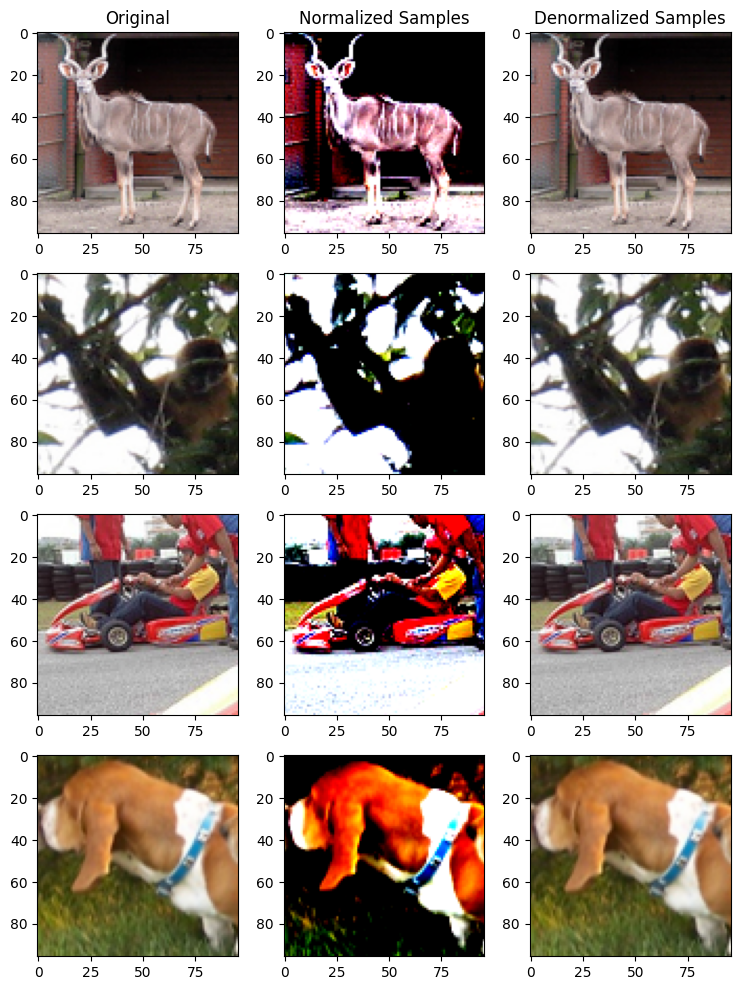

In [24]:
from torchvision.transforms.v2 import Normalize

stl10_unlabeled_mean  = torch.tensor([0.4406, 0.4273, 0.3858])
stl10_unlabeled_std = torch.tensor([0.2687, 0.2613, 0.2685])

denormalize = Compose([Normalize(mean=torch.tensor([0.0,0.0,0.0]), std=1/stl10_unlabeled_std),
                       Normalize(mean=-stl10_unlabeled_mean, std=torch.tensor([1.0,1.0,1.0]))])

denormalized_samples = [denormalize(sample) for sample in normalized_samples]

# Plot the samples
plot_grid_of_images({
    "Original": original_samples,
    "Normalized Samples": normalized_samples,
    "Denormalized Samples": denormalized_samples
})

## 5. Bringing It All Together


In this section, we combine all the previously discussed transforms.

First, we create a single transformation pipeline that applies them sequentially.
Then, we use a Minerva transform to generate two distinct augmented versions of the same input—a common approach in contrastive self-supervised learning.

### 5.1 Combining the transformations into a single pipeline

The code below demonstrates how to combine the previously discussed transformations into a single transformation pipeline, suitable for contrastive learning setups.

Let's generate two lists with transformed samples and plot them side by side.

> Note: For now, we omit the normalization step to make the visualizations easier to interpret.

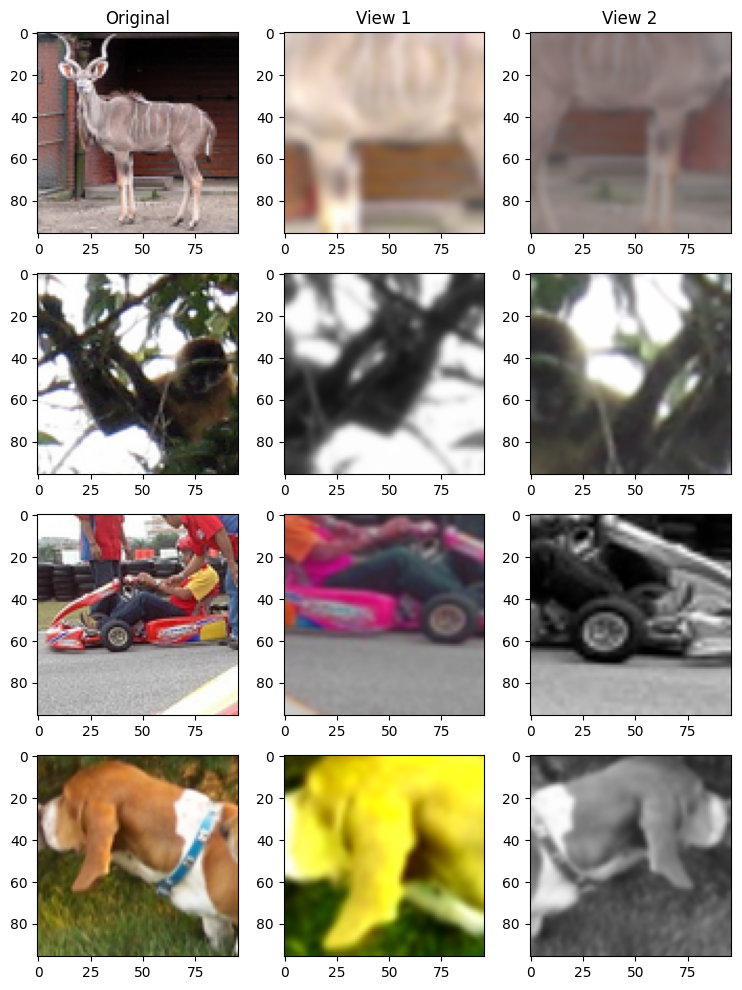

In [25]:
stl10_unlabeled_mean  = torch.tensor([0.4406, 0.4273, 0.3858])
stl10_unlabeled_std = torch.tensor([0.2687, 0.2613, 0.2685])

combined_transforms = Compose([
    ToImage(),
    ToDtype(torch.float32, scale=True),
    RandomHorizontalFlip(),
    RandomResizedCrop(size=96),
    RandomApply([ColorJitter(brightness=0.5,contrast=0.5,saturation=0.5,hue=0.1)], p=0.8),
    RandomGrayscale(p=0.2),
    GaussianBlur(kernel_size=9),
    # Normalize(mean=stl10_unlabeled_mean, std=stl10_unlabeled_std)
])

transformed_samples_v1 = [combined_transforms(sample) for sample in original_samples]
transformed_samples_v2 = [combined_transforms(sample) for sample in original_samples]

# Plot the samples
plot_grid_of_images({
    "Original": original_samples,
    "View 1": transformed_samples_v1,
    "View 2": transformed_samples_v2
})

Note that for each sample, we generate two distinct views by applying random image transformations.
Ideally, these transformations should alter the appearance of the image while preserving its semantic content—for example, if the original image contains a dog, both transformed versions should still be recognizable as a dog.

### 5.2 Producing multiple views for contrastive learning

When training models with contrastive learning it is often usefull to adapt the dataset so that when accessing a sample, instead of the original sample, a pair os views of this sample is retrieved.

To this end, we will use a Minerva data transform that takes a transform pipeline and applies this pipeline twice on a sample to produce two version ("views") of this sample.

The following code shows how to combine a transformation pipeline with Minerva `ContrastiveTransform`.

In [26]:
# Torchvision transforms
from torchvision.transforms.v2 import ToImage, ToDtype, RandomHorizontalFlip, RandomResizedCrop, RandomApply, ColorJitter, RandomGrayscale, GaussianBlur, Normalize
# Minerva Contrastive transform
from minerva.transforms.transform import ContrastiveTransform

transform_pipeline = Compose([
    ToImage(),
    ToDtype(torch.float32, scale=True),
    RandomHorizontalFlip(),
    RandomResizedCrop(size=96),
    RandomApply([ColorJitter(brightness=0.5,contrast=0.5,saturation=0.5,hue=0.1)], p=0.8),
    RandomGrayscale(p=0.2),
    GaussianBlur(kernel_size=9),
    Normalize(mean=stl10_unlabeled_mean, std=stl10_unlabeled_std)
])

contrastive_transform = ContrastiveTransform(transform_pipeline)

contrastive_dataset = torchvision.datasets.STL10(root="data", split="unlabeled",  download=True,
                                                 transform=contrastive_transform)

Now, whenever we acces a sample from this dataset, it will return a pair with two randomly generated views of the sample.

For example:

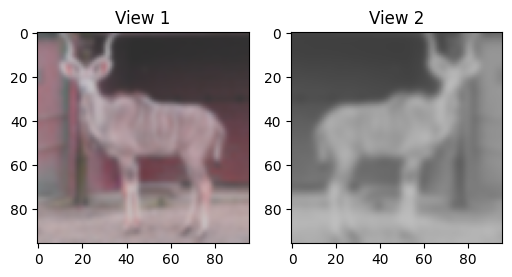

In [27]:
(view1, view2), label = contrastive_dataset[0]

# Plot the samples -- use the denormalization function to improve visualization
plot_grid_of_images({
    "View 1": [denormalize(view1)],
    "View 2": [denormalize(view2)]
})


Let's do it for multiple samples.

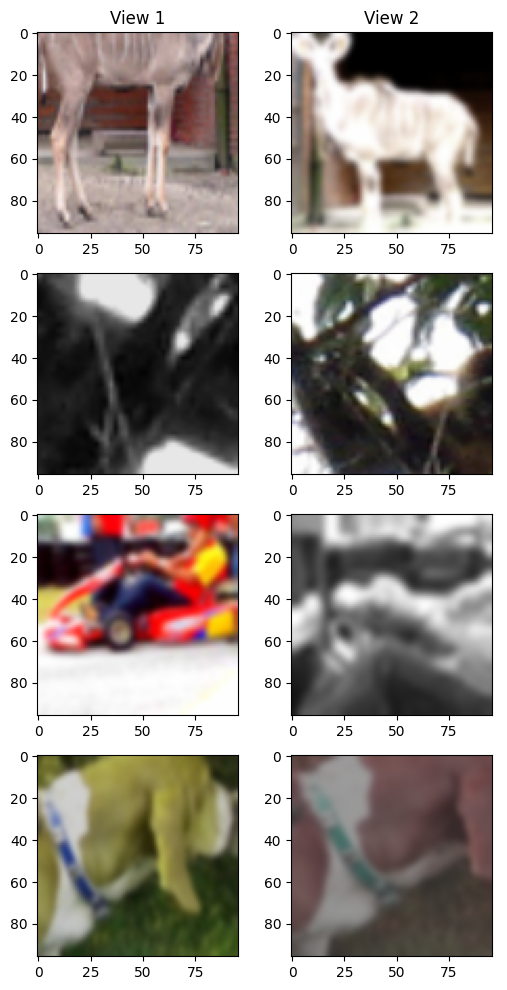

In [28]:
# Build a list with samples 0, 42, 51, and 96
samples = [contrastive_dataset[0], contrastive_dataset[42], contrastive_dataset[51], contrastive_dataset[96]]

# Generate two lists with views v1 and v2 from these samples.
view1_l = [denormalize(v1) for (v1, v2), label in samples]
view2_l = [denormalize(v2) for (v1, v2), label in samples]

# Plot the lists side-by-side
plot_grid_of_images({
    "View 1": view1_l,
    "View 2": view2_l
})


## <a id="sec_6"> 6. Exercises</a>


* **Color Sensitivity in the Transformation Pipeline**: Referring to the transformation pipeline described in Section 5.2, propose modifications that would make the learned representations sensitive to color, i.e., remove the current color invariance. Discuss with your colleagues the implications of these changes on the model's ability to learn visual features.

* **Impact of Transformations on STL-10 Images**: Explore the available [Torchvision transformations](https://pytorch.org/vision/main/transforms.html) and analyze their effects on the STL-10 image dataset.
  Consider enhancing Section 4 of this notebook by incorporating new subsections that demonstrate and evaluate these transformations.

* **Reproducing the SimCLR Contrastive Pipeline**: Review the [SimCLR paper](https://arxiv.org/pdf/2002.05709) and implement a contrastive learning pipeline using the same transformation strategies and configuration settings described by the authors.